<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1950-01-03,3
1950-01-04,3
1950-01-05,3
1950-01-06,3
1950-01-09,3


In [6]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5]

In [7]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [8]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [9]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [10]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
MIN_YEARS = 5
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(2012, 9, 5),
 datetime.date(2022, 9, 3),
 datetime.date(2017, 9, 2),
 5)

In [11]:
START, TODAY

(datetime.date(2012, 9, 5), datetime.date(2022, 9, 3))

In [12]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [13]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [14]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [15]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [16]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [17]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [18]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [19]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [20]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    state_sharpes = get_sharpes_by_state(data)
    return state_sharpes

In [21]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI IVR JMSB KERX KRMD LCA LIN LPI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_34452/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO NYXH OLLI ORCL PACX PCX PGHD PLL POWW 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_34452/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1
/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_34452/1541653759.py:5: RuntimeWarning: invalid value encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


PSAG PXMD RADI RENT RLTY RRI SAGA SCLN SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_34452/1541653759.py:5: RuntimeWarning: divide by zero encountered in divide
  returns = x[1:n] / x[0:(n-1)] - 1


YDKN ZOM 

In [22]:
df = pd.concat(dfs, axis=0)
df.head()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
A,0.786353,-3.461018,1.098054,1.122927,1.275524,3.070949,3.209541
AA,0.436086,-2.381248,1.413614,0.219841,0.108732,1.775194,1.213354
AAIC,0.018250,-1.189653,0.101138,1.505511,0.410220,1.667092,0.664249
AAL,0.287998,-2.314977,0.757442,1.112278,0.322919,1.707227,1.629506
AAME,0.332655,-0.751945,0.915456,0.580170,0.497002,0.093601,-0.193794


In [23]:
df.tail()

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
ZUMZ,0.228372,-1.515600,0.504900,-0.252534,0.903038,0.968386,0.654910
ZWS,0.354966,-2.530468,0.557051,0.070016,0.007978,2.451861,2.786198
ZYME,0.129709,-1.387057,-0.509290,-1.679981,1.172419,2.637493,1.356613
ZYNE,0.136966,-2.161102,-0.647540,1.590663,0.899051,-0.060131,1.281224
ZYXI,0.818016,1.287661,0.237706,1.030025,0.265595,-0.089947,1.703991


In [24]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [66]:
# Weighted Best
weighted = 0.25 * df.sharpe_0 + df.sharpe_1 + 0.25 * df.sharpe_2
best_weighted = weighted.sort_values(ascending=False)[:20]
df.loc[best_weighted.index, :]

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
KREF,0.314739,-0.860893,1.068006,8.202578,1.097796,1.054265,0.795719
FCPT,0.589207,-0.490599,1.431646,4.782148,1.069015,-1.104168,1.831193
EXR,1.002172,-1.281449,2.296653,2.079920,1.525400,2.482542,0.383446
PSA,0.650748,-1.573871,2.381544,1.504720,0.706028,1.554577,-0.198138
LSI,0.792455,-1.354776,2.245297,1.579082,0.779205,1.798504,0.413647
CUBE,0.786320,-1.394105,2.159637,1.930519,1.331625,1.262788,0.260299
FFDF,1.231458,0.516896,1.683991,1.323526,0.883937,1.043475,1.494569
RA,0.468796,-0.899282,0.980842,5.337465,3.184712,2.129093,2.982667
WCN,1.166216,-2.464539,2.097525,2.426014,2.512514,1.347411,2.938991
DFIN,0.430718,-1.072630,0.760955,6.229535,-0.281270,1.530202,0.866065


In [67]:
# Hedged best
hedged = (
    df[['sharpe_0', 'sharpe_1', 'sharpe_2']]
    .min(axis=1)
    .sort_values(ascending=False)[:20])
df.loc[hedged.index, :]

,sharpe,sharpe_0,sharpe_1,sharpe_2,sharpe_3,sharpe_4,sharpe_5
GBOX,1.203296,1.028573,1.366265,0.879166,1.456559,1.222836,1.200276
GME,0.755948,0.861828,1.041751,2.139710,-0.456684,-0.002475,0.889450
EP,0.961937,1.033869,0.767054,1.297008,1.677714,0.104221,1.173532
OLB,0.461615,0.882370,0.671041,1.021680,1.073377,0.343270,0.698204
IVDA,0.882941,0.779377,0.658898,0.976425,1.906477,0.352420,0.971272
PRTG,0.501919,0.935670,0.651969,1.652120,0.437920,0.898961,0.634190
SOBR,0.671379,1.042512,0.647170,1.274770,1.658017,0.450715,1.142757
IVT,0.344044,0.869428,0.628784,1.156587,-0.025213,-0.638052,-0.258673
NCPL,0.322772,1.146328,0.608716,1.312686,1.044517,1.842803,1.495014
BTTR,0.422151,1.378178,0.607720,0.865024,0.599793,0.914709,0.449682


In [25]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()

In [26]:
CURRENT_STATE

1

In [61]:
best_0 = best_n_by_state(df, 12, 0)
best_1 = best_n_by_state(df, 20, 1)
best_2 = best_n_by_state(df, 10, 2)
best_3 = best_n_by_state(df, 10, 3)

In [62]:
exclude = ['ASTI', 'BRTX', 'FFDF', 'TFG', 'VXRT', 'VXZB']
best_1 = [s for s in best_1 if s not in exclude]
df.loc[best_1, ['sharpe', 'sharpe_0', 'sharpe_1']]

,sharpe,sharpe_0,sharpe_1
PSA,0.650748,-1.573871,2.381544
EXR,1.002172,-1.281449,2.296653
LSI,0.792455,-1.354776,2.245297
CUBE,0.786320,-1.394105,2.159637
TWNK,0.624425,-2.070600,2.104215
WCN,1.166216,-2.464539,2.097525
EVA,0.867700,-1.673559,1.989497
REXR,0.878333,-2.413490,1.971078
NSA,0.896763,-0.885810,1.874567
TSLA,1.159955,-2.607051,1.864281


In [57]:
TEST = 'TSLA'
b = download_data([TEST])
b

In [58]:
data = (
    yf
    .download([TEST], start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
data.index = pd.to_datetime(data.index)
data = data.sort_index()
#data = data.loc[:, data.isnull().sum() != len(data)]
#missing_last = [
#    col for col in list(data) if data[col].isnull()[-1]]
#data.drop(columns=missing_last, inplace=True)
#sys.stdout = std_out
#return data
data.tail()

Date
2022-08-29    284.820007
2022-08-30    277.700012
2022-08-31    275.609985
2022-09-01    277.160004
2022-09-02    270.209991
Name: AdjClose, dtype: float64

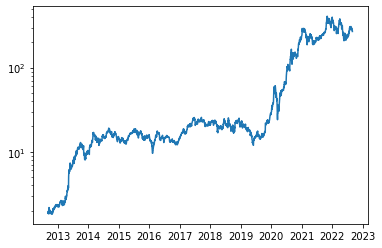

In [59]:
plt.plot(data)
plt.yscale('log');

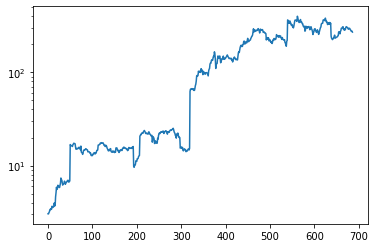

In [60]:
plt.plot(data[states.state == CURRENT_STATE].to_numpy())
plt.yscale('log');

In [33]:
r = get_daily_returns(data)
get_sharpe(r)

0.650748130796559

In [34]:
r.mean()

0.0005426268706305071

In [35]:
r.median()

0.0009044704520435598

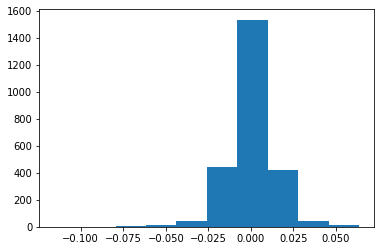

In [36]:
plt.hist(r);